# Kosdaq Scalping

In [5]:
import numpy as np
import pandas as pd

import copy
import src.core.lib.chrono as chrono
from notebooks.helper_functions import *
from notebooks.graphlib import *
from notebooks.orderbook_aggregated import *
pd.options.display.max_columns = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## Parameters and Helper functions

In [6]:
import pickle

def save_to_pickle(data_list, file_path):
    try:
        with open(file_path, 'wb') as file:
            pickle.dump(data_list, file)
        print("Data has been successfully saved to", file_path)
    except Exception as e:
        print("Error occurred while saving data:", e)

def load_from_pickle(file_path):
    try:
        with open(file_path, 'rb') as file:
            data_list = pickle.load(file)
        return data_list
    except Exception as e:
        print("Error occurred while loading data:", e)
        return None

In [7]:
tz = "Asia/Seoul"
beg_date_pd = pd.to_datetime("2023-05-26").tz_localize(tz).date()
end_date_pd = pd.to_datetime("2023-05-26").tz_localize(tz).date()
beg_time = "09:01:00.0"
end_time = "15:19:59.0"
debug=True

futures = {
    "KR4106T60005": {
        "edges_out": ["KR4106T60005"],
        "edges_out_weight": [1.0],
        "name": "kosdaq150_futures",
        "sectype": "FUT",
        "secsubtype": "EQUITY_INDEX_FUT",
        "multiplier": 10000,
        "tick_size": 0.1,
        "creation_unit": None,
        "leverage": None,
    }
}

etps = {
    "KRG530001079": {
        "name": "samsung_kosdaq150_futures_2x_inverse_etn",
        "sectype": "STK",
        "secsubtype": "EQUITY_INDEX_FUTURES_2X_INVERSE_ETN",
        "multiplier": 1,
        "tick_size": 5,
        "leverage": -2,
        "creation_unit": None,
        "edges_out_weight": [1.0],
        "edges_out": ["KR4106T60005"],
    },
    "KRG520000578": {
        "name": "mirae_kosdaq150_futures_2x_inverse_etn",
        "sectype": "STK",
        "secsubtype": "EQUITY_INDEX_FUTURES_2X_INVERSE_ETN",
        "multiplier": 1,
        "tick_size": 5,
        "leverage": -2,
        "creation_unit": None,
        "edges_out_weight": [1.0],
        "edges_out": ["KR4106T60005"],
    },
    "KRG570000825": {
        "name": "true_kosdaq150_futures_2x_inverse_etn",
        "sectype": "STK",
        "secsubtype": "EQUITY_INDEX_FUTURES_2X_INVERSE_ETN",
        "multiplier": 1,
        "tick_size": 5,
        "leverage": -2,
        "creation_unit": None,
        "edges_out_weight": [1.0],
        "edges_out": ["KR4106T60005"],
    },
    "KRG580000443": {
        "name": "kb_kosdaq150_futures_2x_inverse_etn",
        "sectype": "STK",
        "secsubtype": "EQUITY_INDEX_FUTURES_2X_INVERSE_ETN",
        "multiplier": 1,
        "tick_size": 5,
        "leverage": -2,
        "creation_unit": None,
        "edges_out_weight": [1.0],
        "edges_out": ["KR4106T60005"],
    }, 
}

## Scalping

In [4]:
debug = True

for date in pd.date_range(beg_date_pd, end_date_pd):
    date_str = date.strftime("%Y-%m-%d")
    print(date_str)

    # check if the date is a trading date, if not continue
    if not is_trading_date(date_str):
        continue

    # create a graph structure
    securities_graph = Graph()

    # add nodes
    for security_id, info in list(futures.items()) + list(etps.items()):
        securities_graph.update_node(
            Node(
                isin=security_id,
                date_str=date_str,
                name=info["name"],
                sectype=info["sectype"],
                secsubtype=info["secsubtype"],
                multiplier=info["multiplier"],
                tick_size=info["tick_size"],
                creation_unit=info["creation_unit"],
                leverage=info["leverage"],
                tz=tz,
                debug=debug
            )
        )

    # add edges
    for security_id, info in list(futures.items()) + list(etps.items()):
        for neighbor_id, weight in zip(info["edges_out"], info["edges_out_weight"]):
            securities_graph.update_edge(
                securities_graph.nodes[security_id],
                securities_graph.nodes[neighbor_id],
                Relation(weight)
            )


    # get combined marketdepth data
    marketdepth_data = MarketdepthData(
        list(etps.keys()) + list(futures.keys()),
        date_str,
        beg_time,
        end_time,
        tz=tz,
        debug=debug
    )

    agg_orderbook = AggregatedOrderbook()
    upper_channels = []
    lower_channels = []
    datetimes = []
    for k, row in enumerate(marketdepth_data):
        # get security node
        node = securities_graph.get(row["isin"])
        
        # update node with new marketdepth data
        node.orderbook.update(row)

        # recursive update
        for node_dest, relation in node.neighbors_out.items():
            node.orderbook.convert(
                node.leverage,
                node.prev_day_iv_nav,
                node_dest.isin,
                node_dest.orderbook.laskprice(1),
                node_dest.orderbook.lbidprice(1),
                node_dest.multiplier,
                node_dest.prev_day_closing_price 
            )
            agg_orderbook.update(node.orderbook, row["system_datetime"])

        for node_src, relation in node.neighbors_in.items():
            node.orderbook.convert(
                node_src.leverage,
                node_src.prev_day_iv_nav,
                node.isin,
                node.orderbook.laskprice(1),
                node.orderbook.lbidprice(1),
                node.multiplier,
                node.prev_day_closing_price
            )
            agg_orderbook.update(node_src.orderbook, row["system_datetime"])

            futures_l1askprice = agg_orderbook.agg_l1askprice(list(futures.keys()))
            futures_l1bidprice = agg_orderbook.agg_l1bidprice(list(futures.keys()))
            etps_l1askprice = agg_orderbook.agg_l1askprice(list(etps.keys()))
            etps_l1bidprice = agg_orderbook.agg_l1bidprice(list(etps.keys()))

            if (futures_l1askprice is not None and
                    futures_l1bidprice is not None and 
                    etps_l1askprice is not None and
                    etps_l1bidprice is not None):
                datetimes.append(row["system_datetime"]) 
                upper_channels.append(
                     futures_l1askprice - etps_l1bidprice
                ) 
                lower_channels.append(
                     futures_l1bidprice - etps_l1askprice
                )



2023-05-26


In [10]:
#save_to_pickle(
#    {"upper": upper_channels, "lower": lower_channels, "datetimes": datetimes}, 
#    "channels.pkl"    
#)
data = load_from_pickle(
    "channels.pkl"
)

upper_channels_ld = data["upper"]
lower_channels_ld = data["lower"]
datetimes_ld = data["datetimes"]

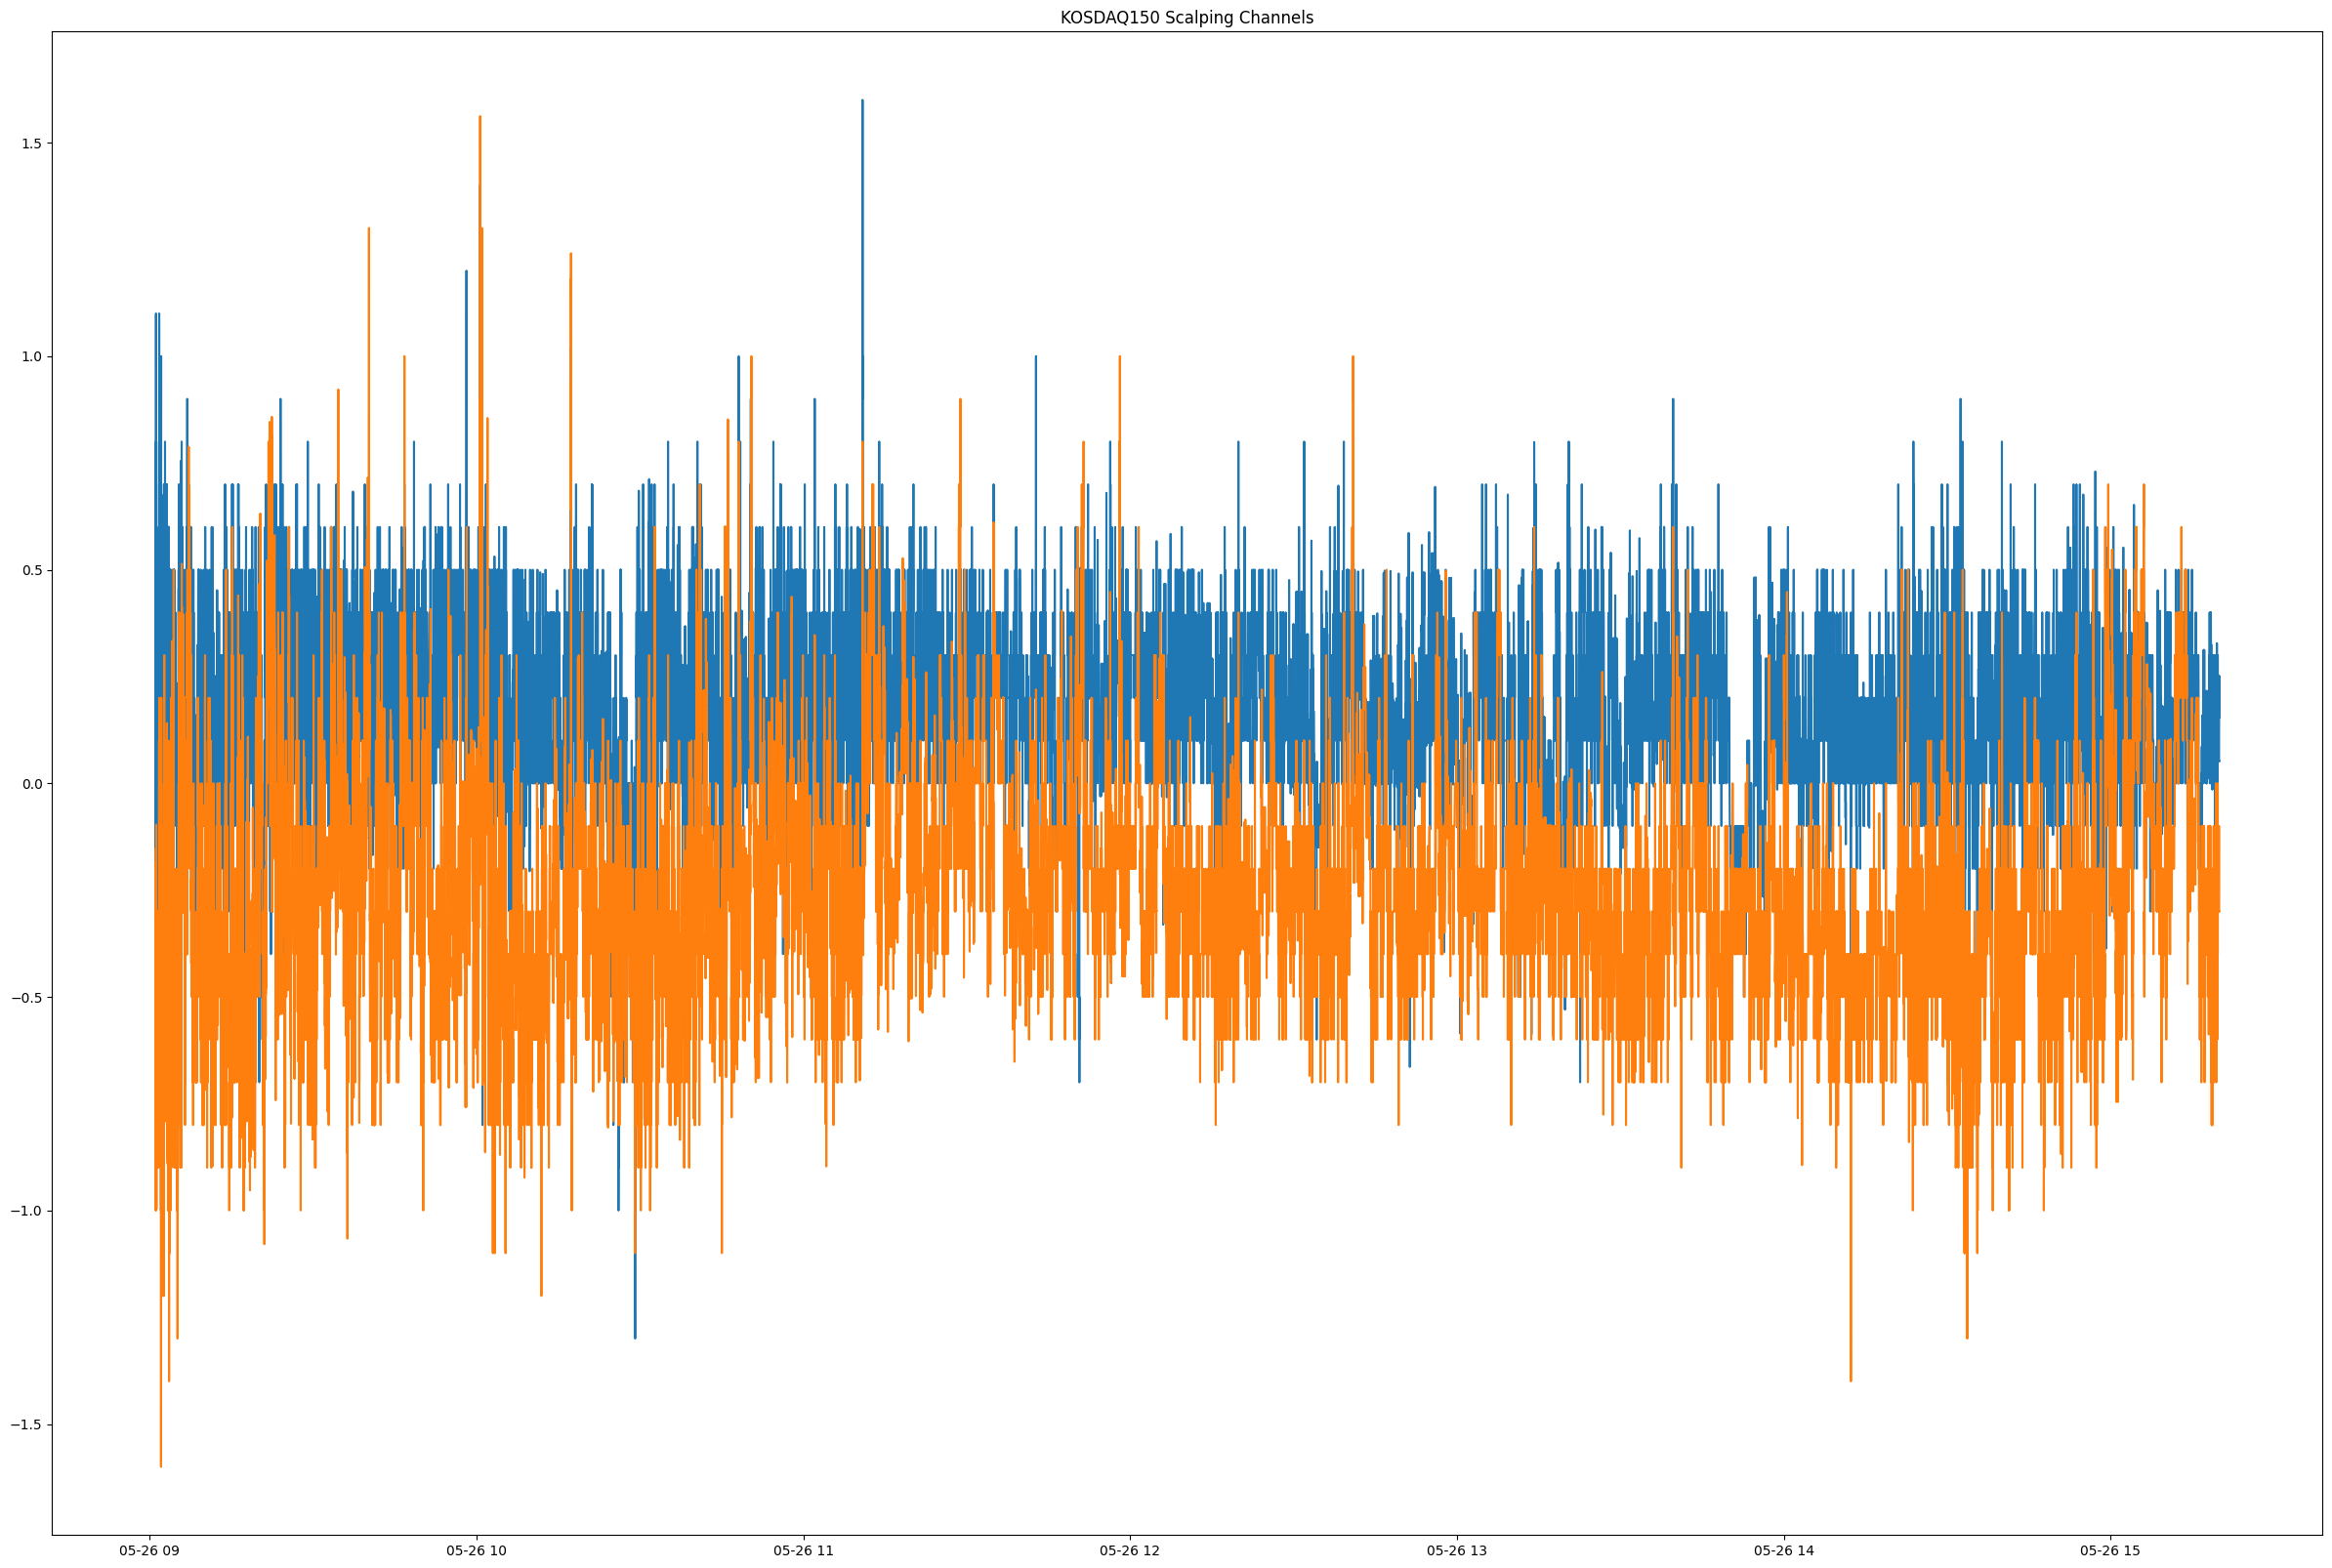

In [11]:
plt.figure(figsize=(30, 20))
plt.plot(datetimes_ld, upper_channels_ld)
plt.plot(datetimes_ld, lower_channels_ld)
plt.title("KOSDAQ150 Scalping Channels")
plt.show()


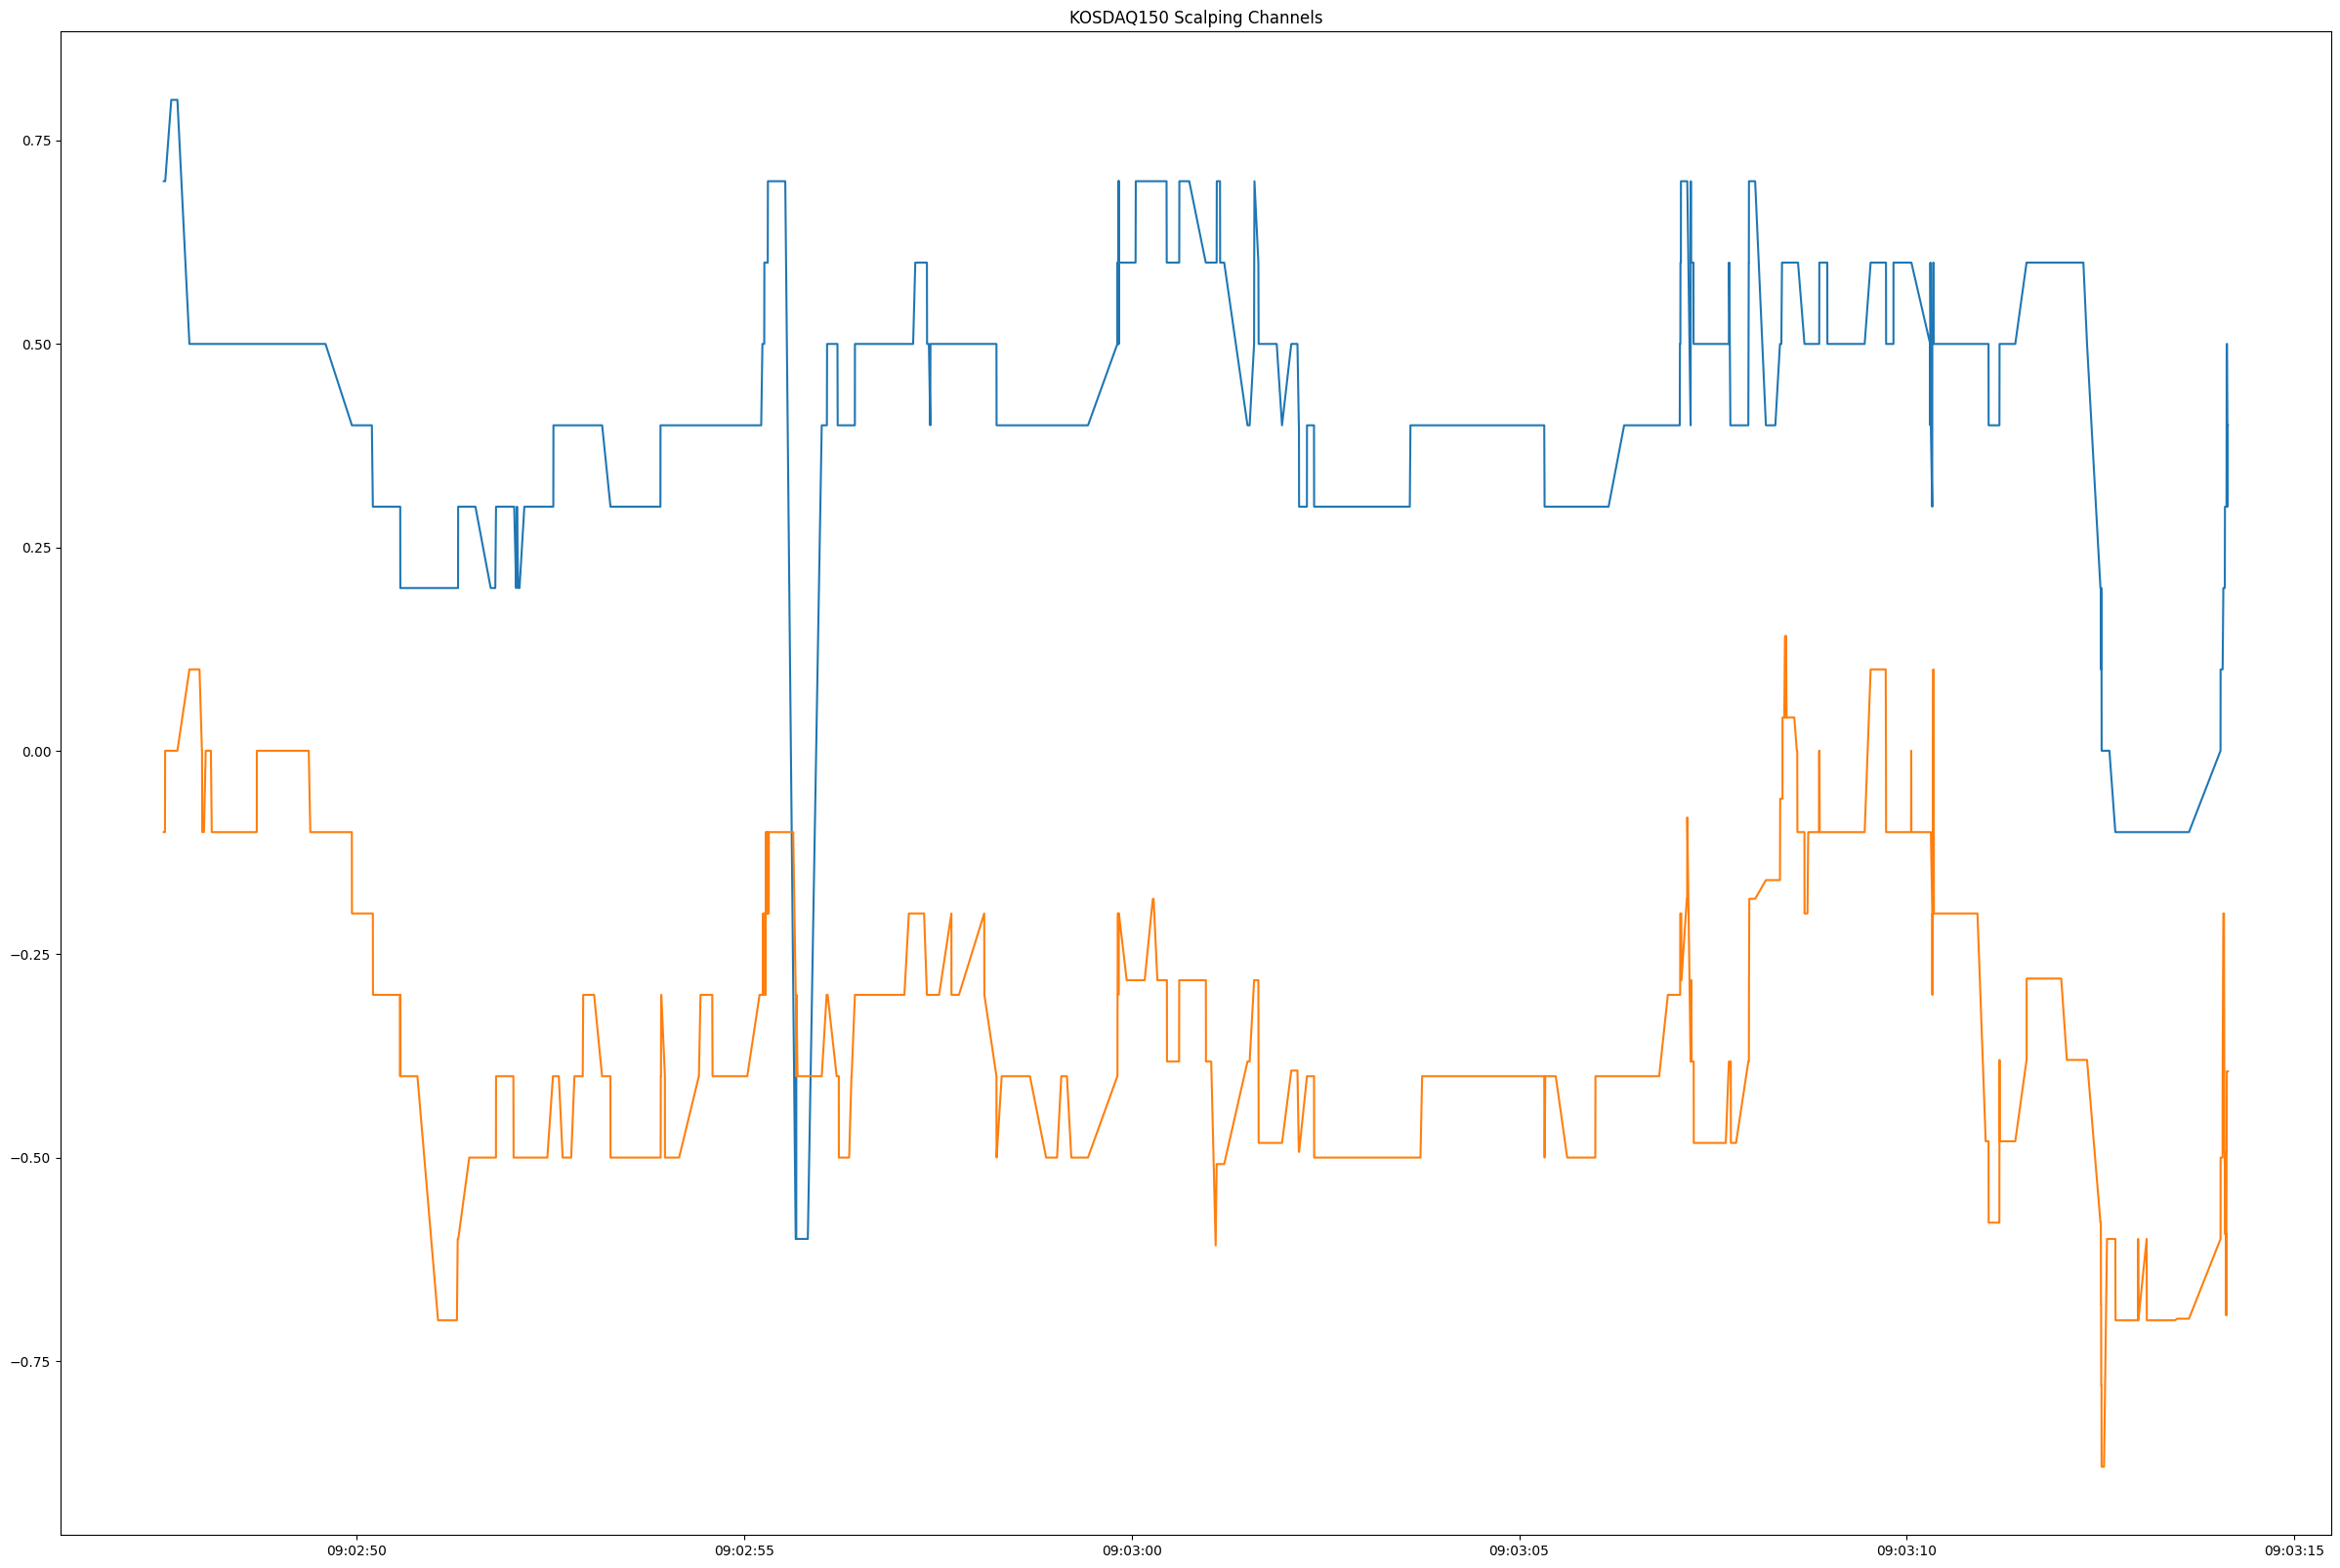

In [25]:
b, e = 27500, 35000  # 09:02:55.819991823+09:00
plt.figure(figsize=(30, 20))
plt.plot(datetimes_ld[b:e], upper_channels_ld[b:e])
plt.plot(datetimes_ld[b:e], lower_channels_ld[b:e])
plt.title("KOSDAQ150 Scalping Channels")
plt.show()


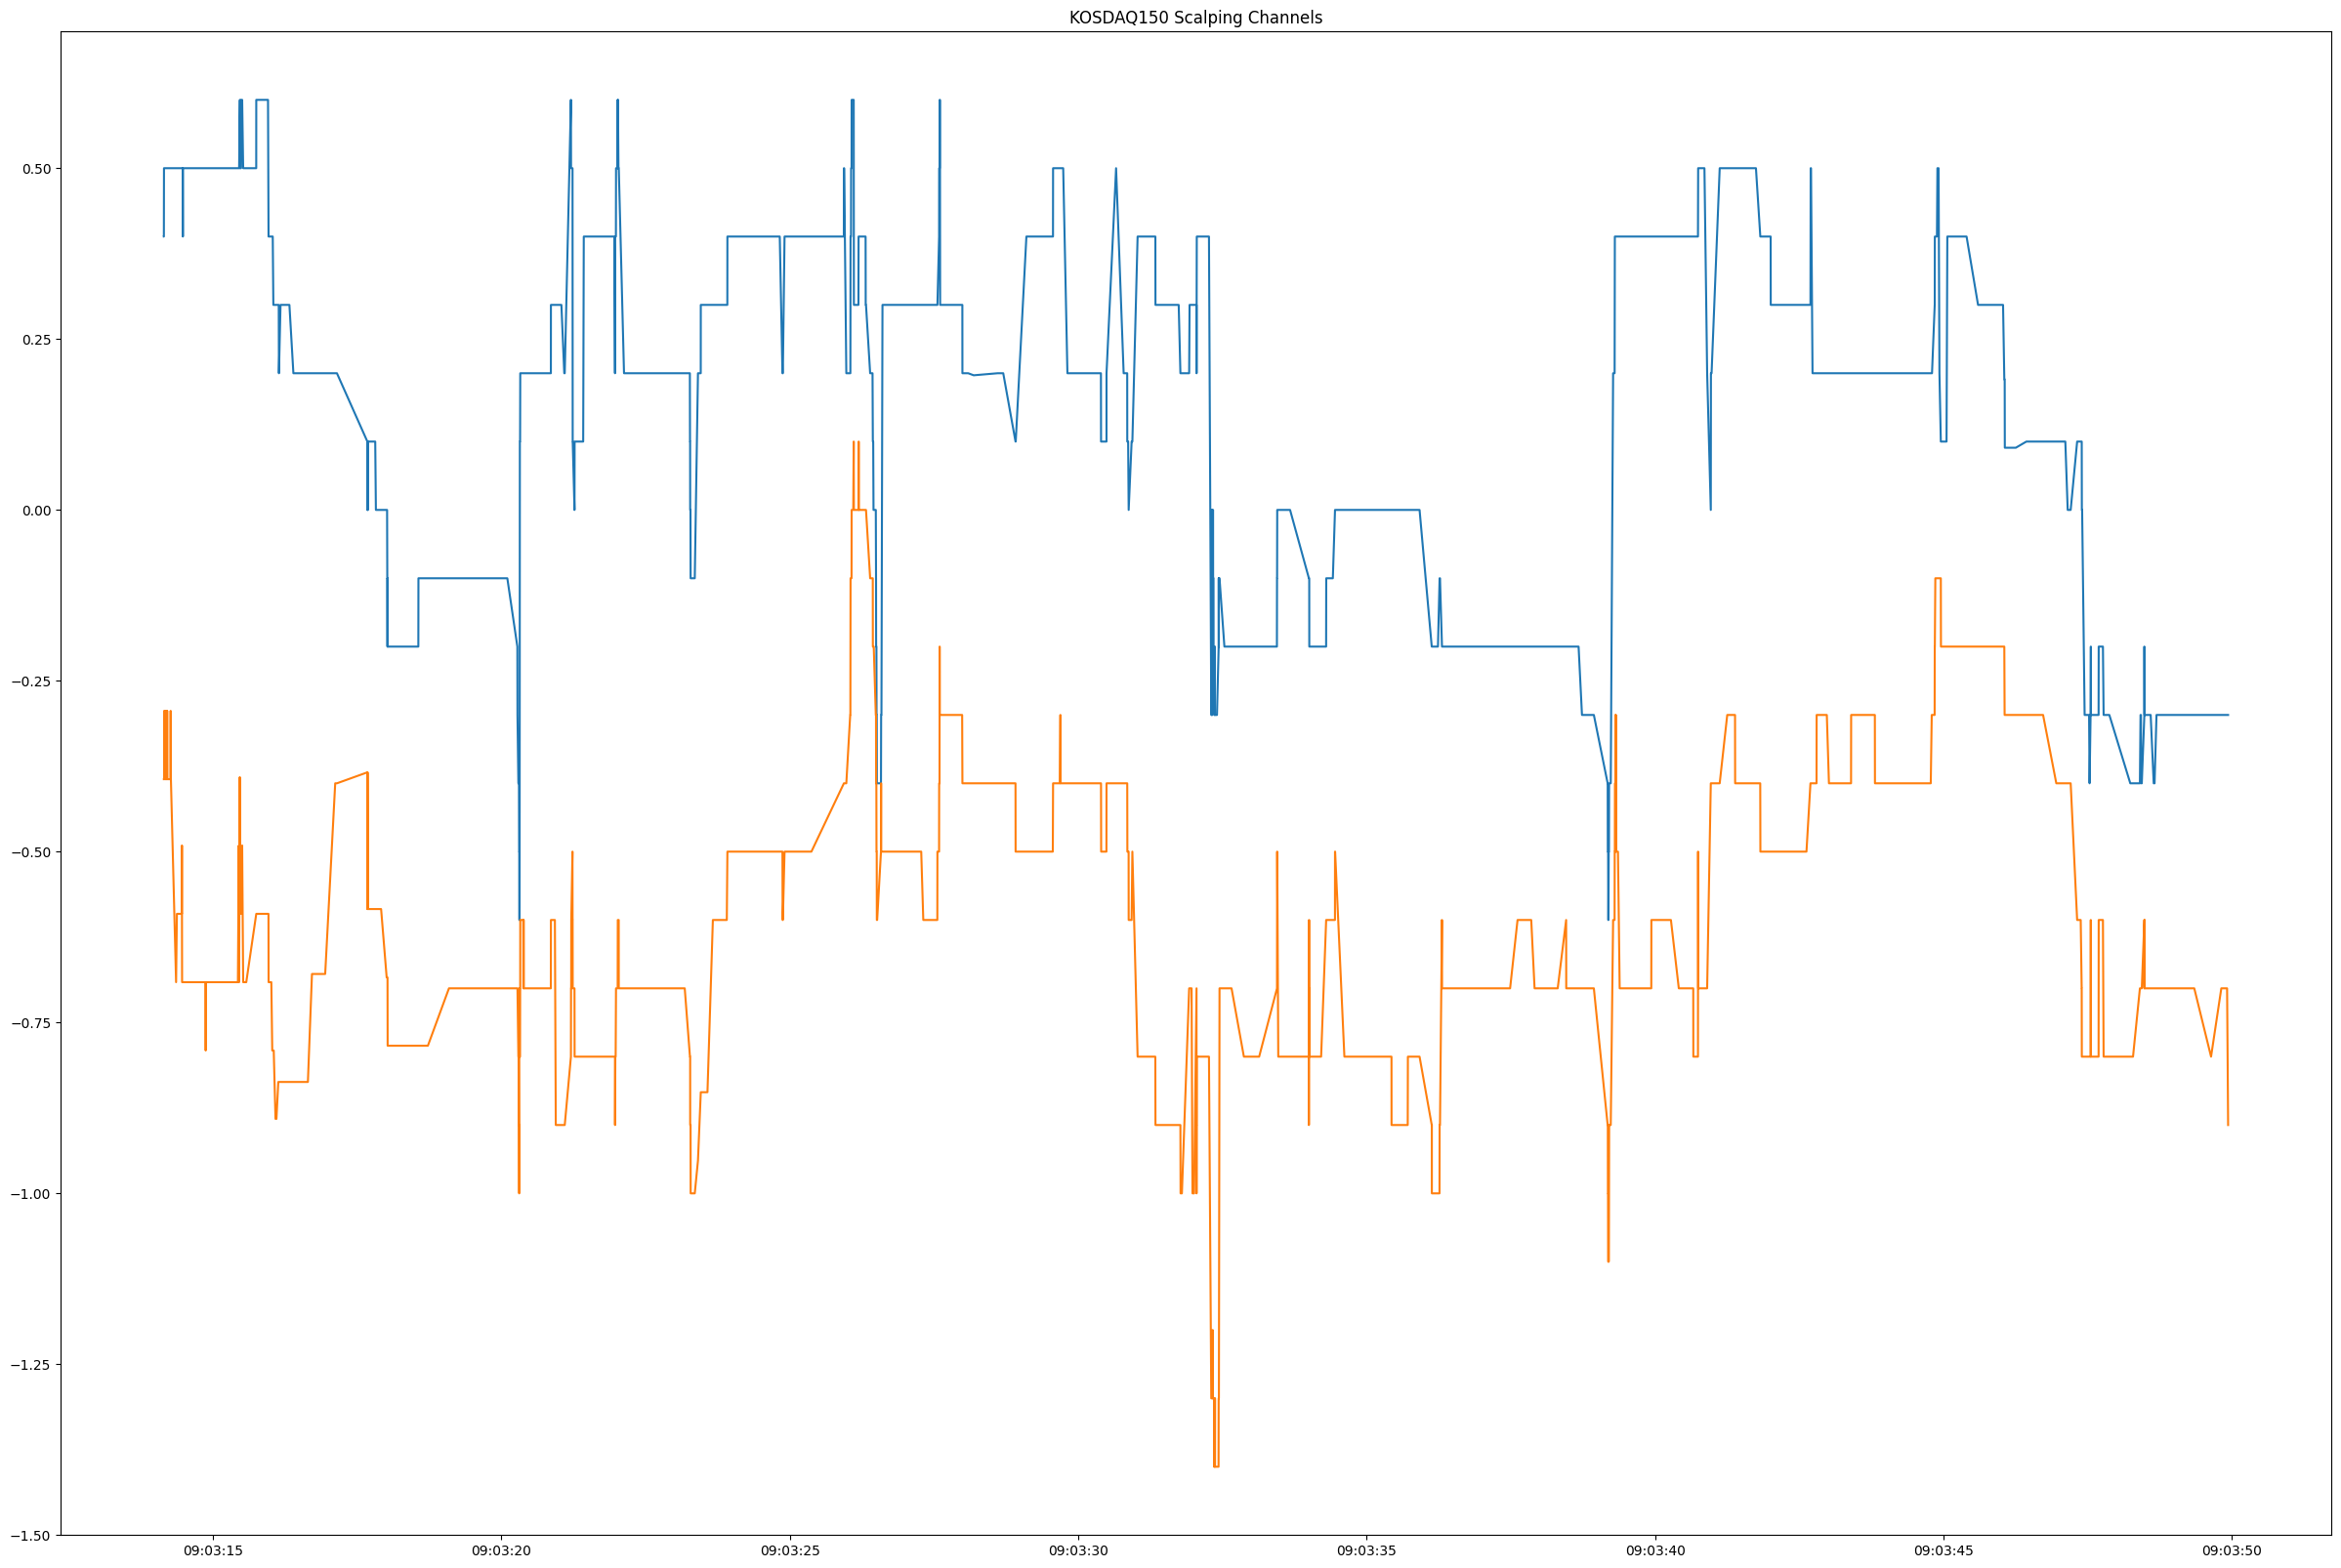

In [27]:
b, e = 35000, 45000  # 2023-05-26 09:03:18.559497668+09:00
plt.figure(figsize=(30, 20))
plt.plot(datetimes_ld[b:e], upper_channels_ld[b:e])
plt.plot(datetimes_ld[b:e], lower_channels_ld[b:e])
plt.title("KOSDAQ150 Scalping Channels")
plt.show()

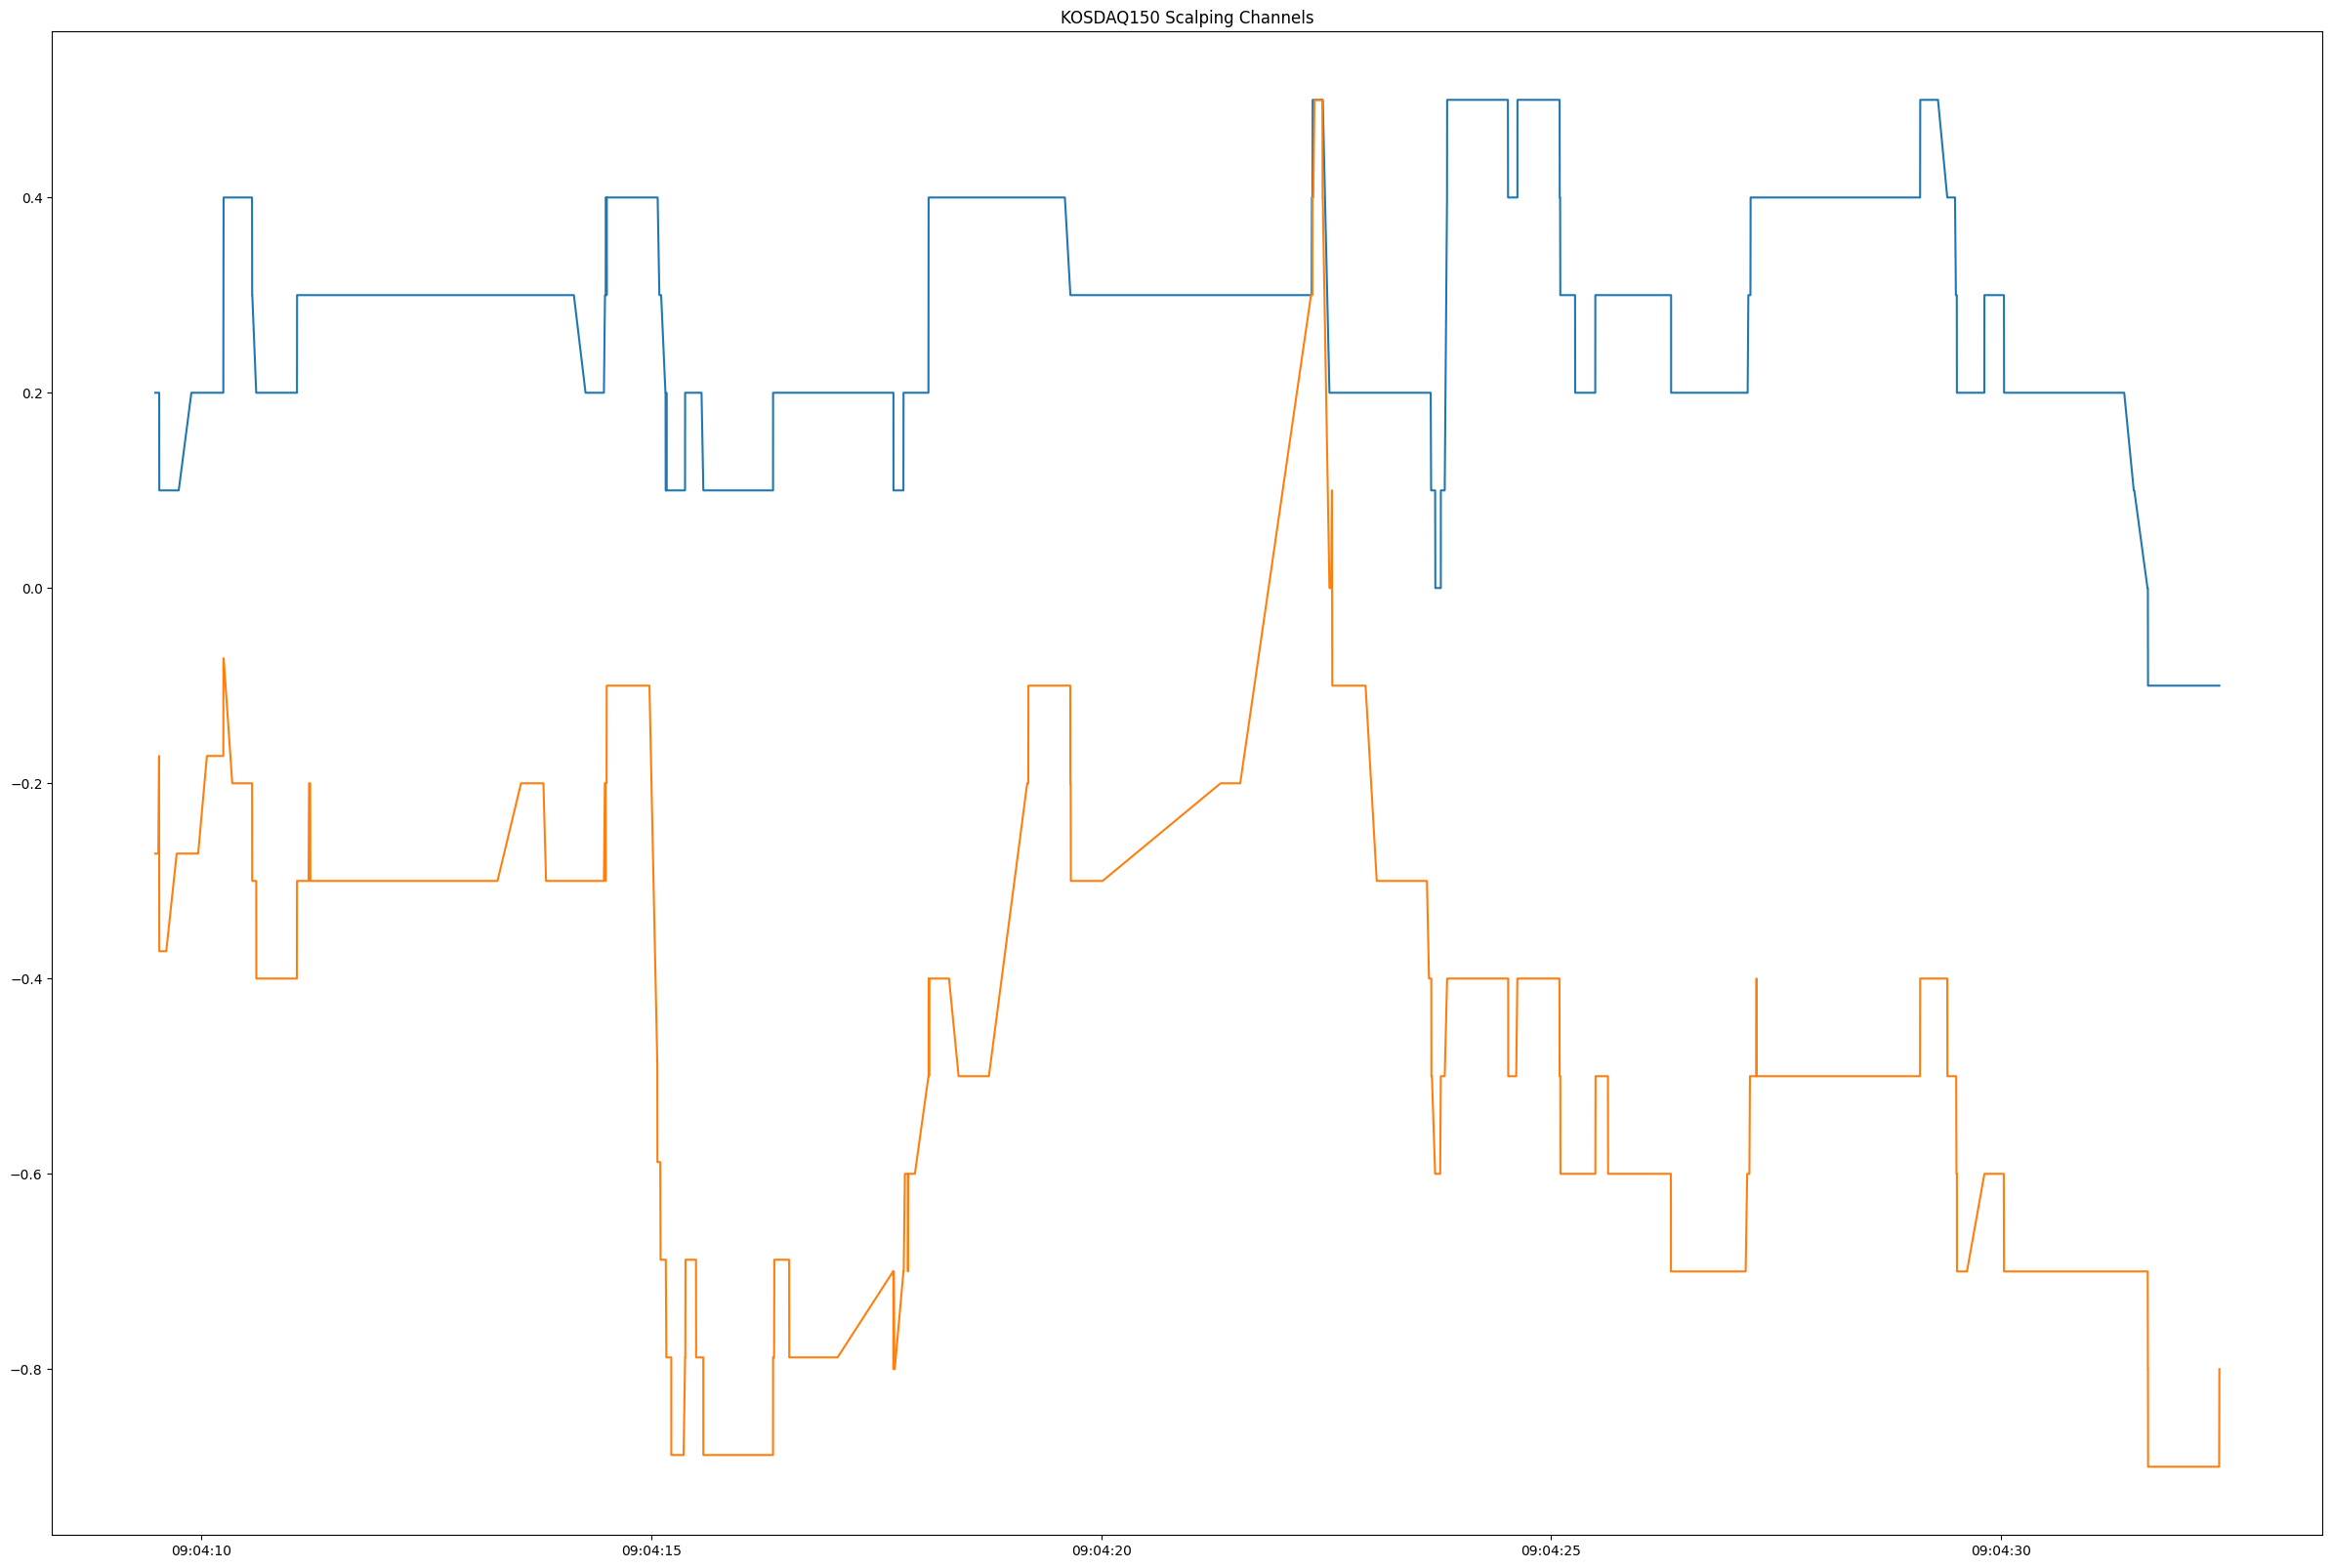

In [29]:
b, e = 50000, 55000 # 09:04:19.662880960+09:00 
plt.figure(figsize=(30, 20))
plt.plot(datetimes_ld[b:e], upper_channels_ld[b:e])
plt.plot(datetimes_ld[b:e], lower_channels_ld[b:e])
plt.title("KOSDAQ150 Scalping Channels")
plt.show()

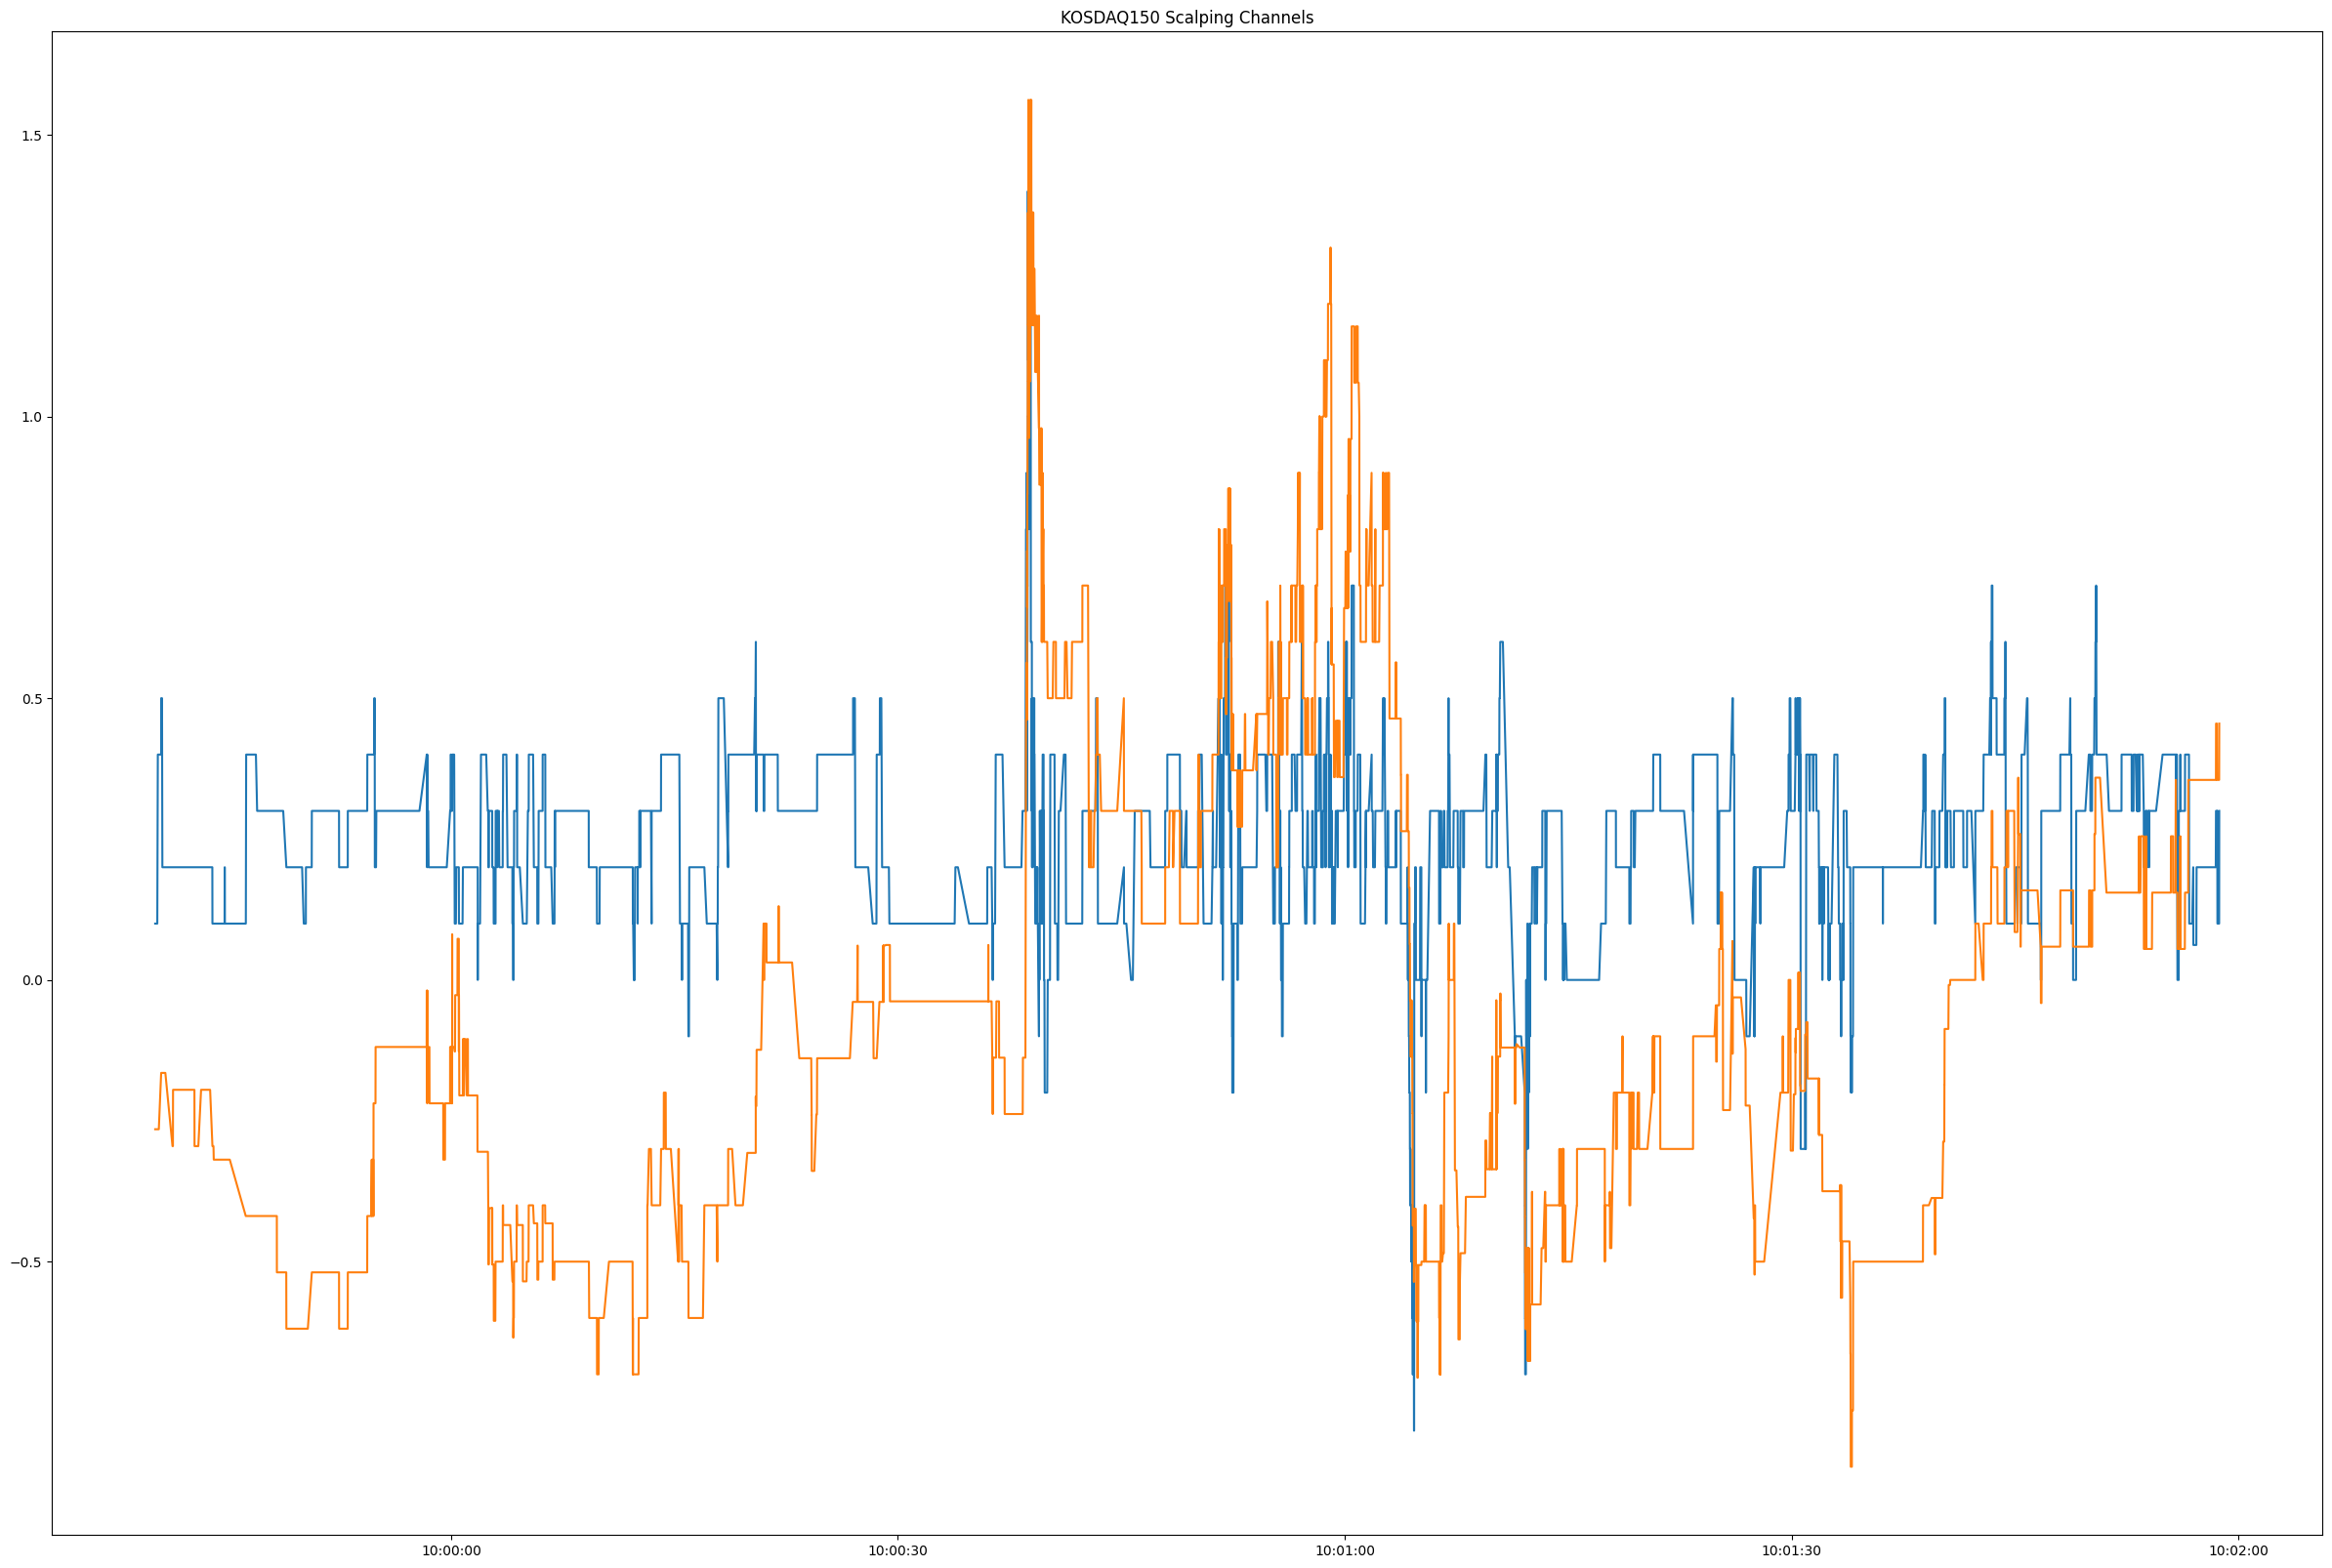

In [62]:
b, e = 1220000, 1300000 # 10:00:38.516296773+09:00
plt.figure(figsize=(30, 20))
plt.plot(datetimes_ld[b:e], upper_channels_ld[b:e])
plt.plot(datetimes_ld[b:e], lower_channels_ld[b:e])
plt.title("KOSDAQ150 Scalping Channels")
plt.show()

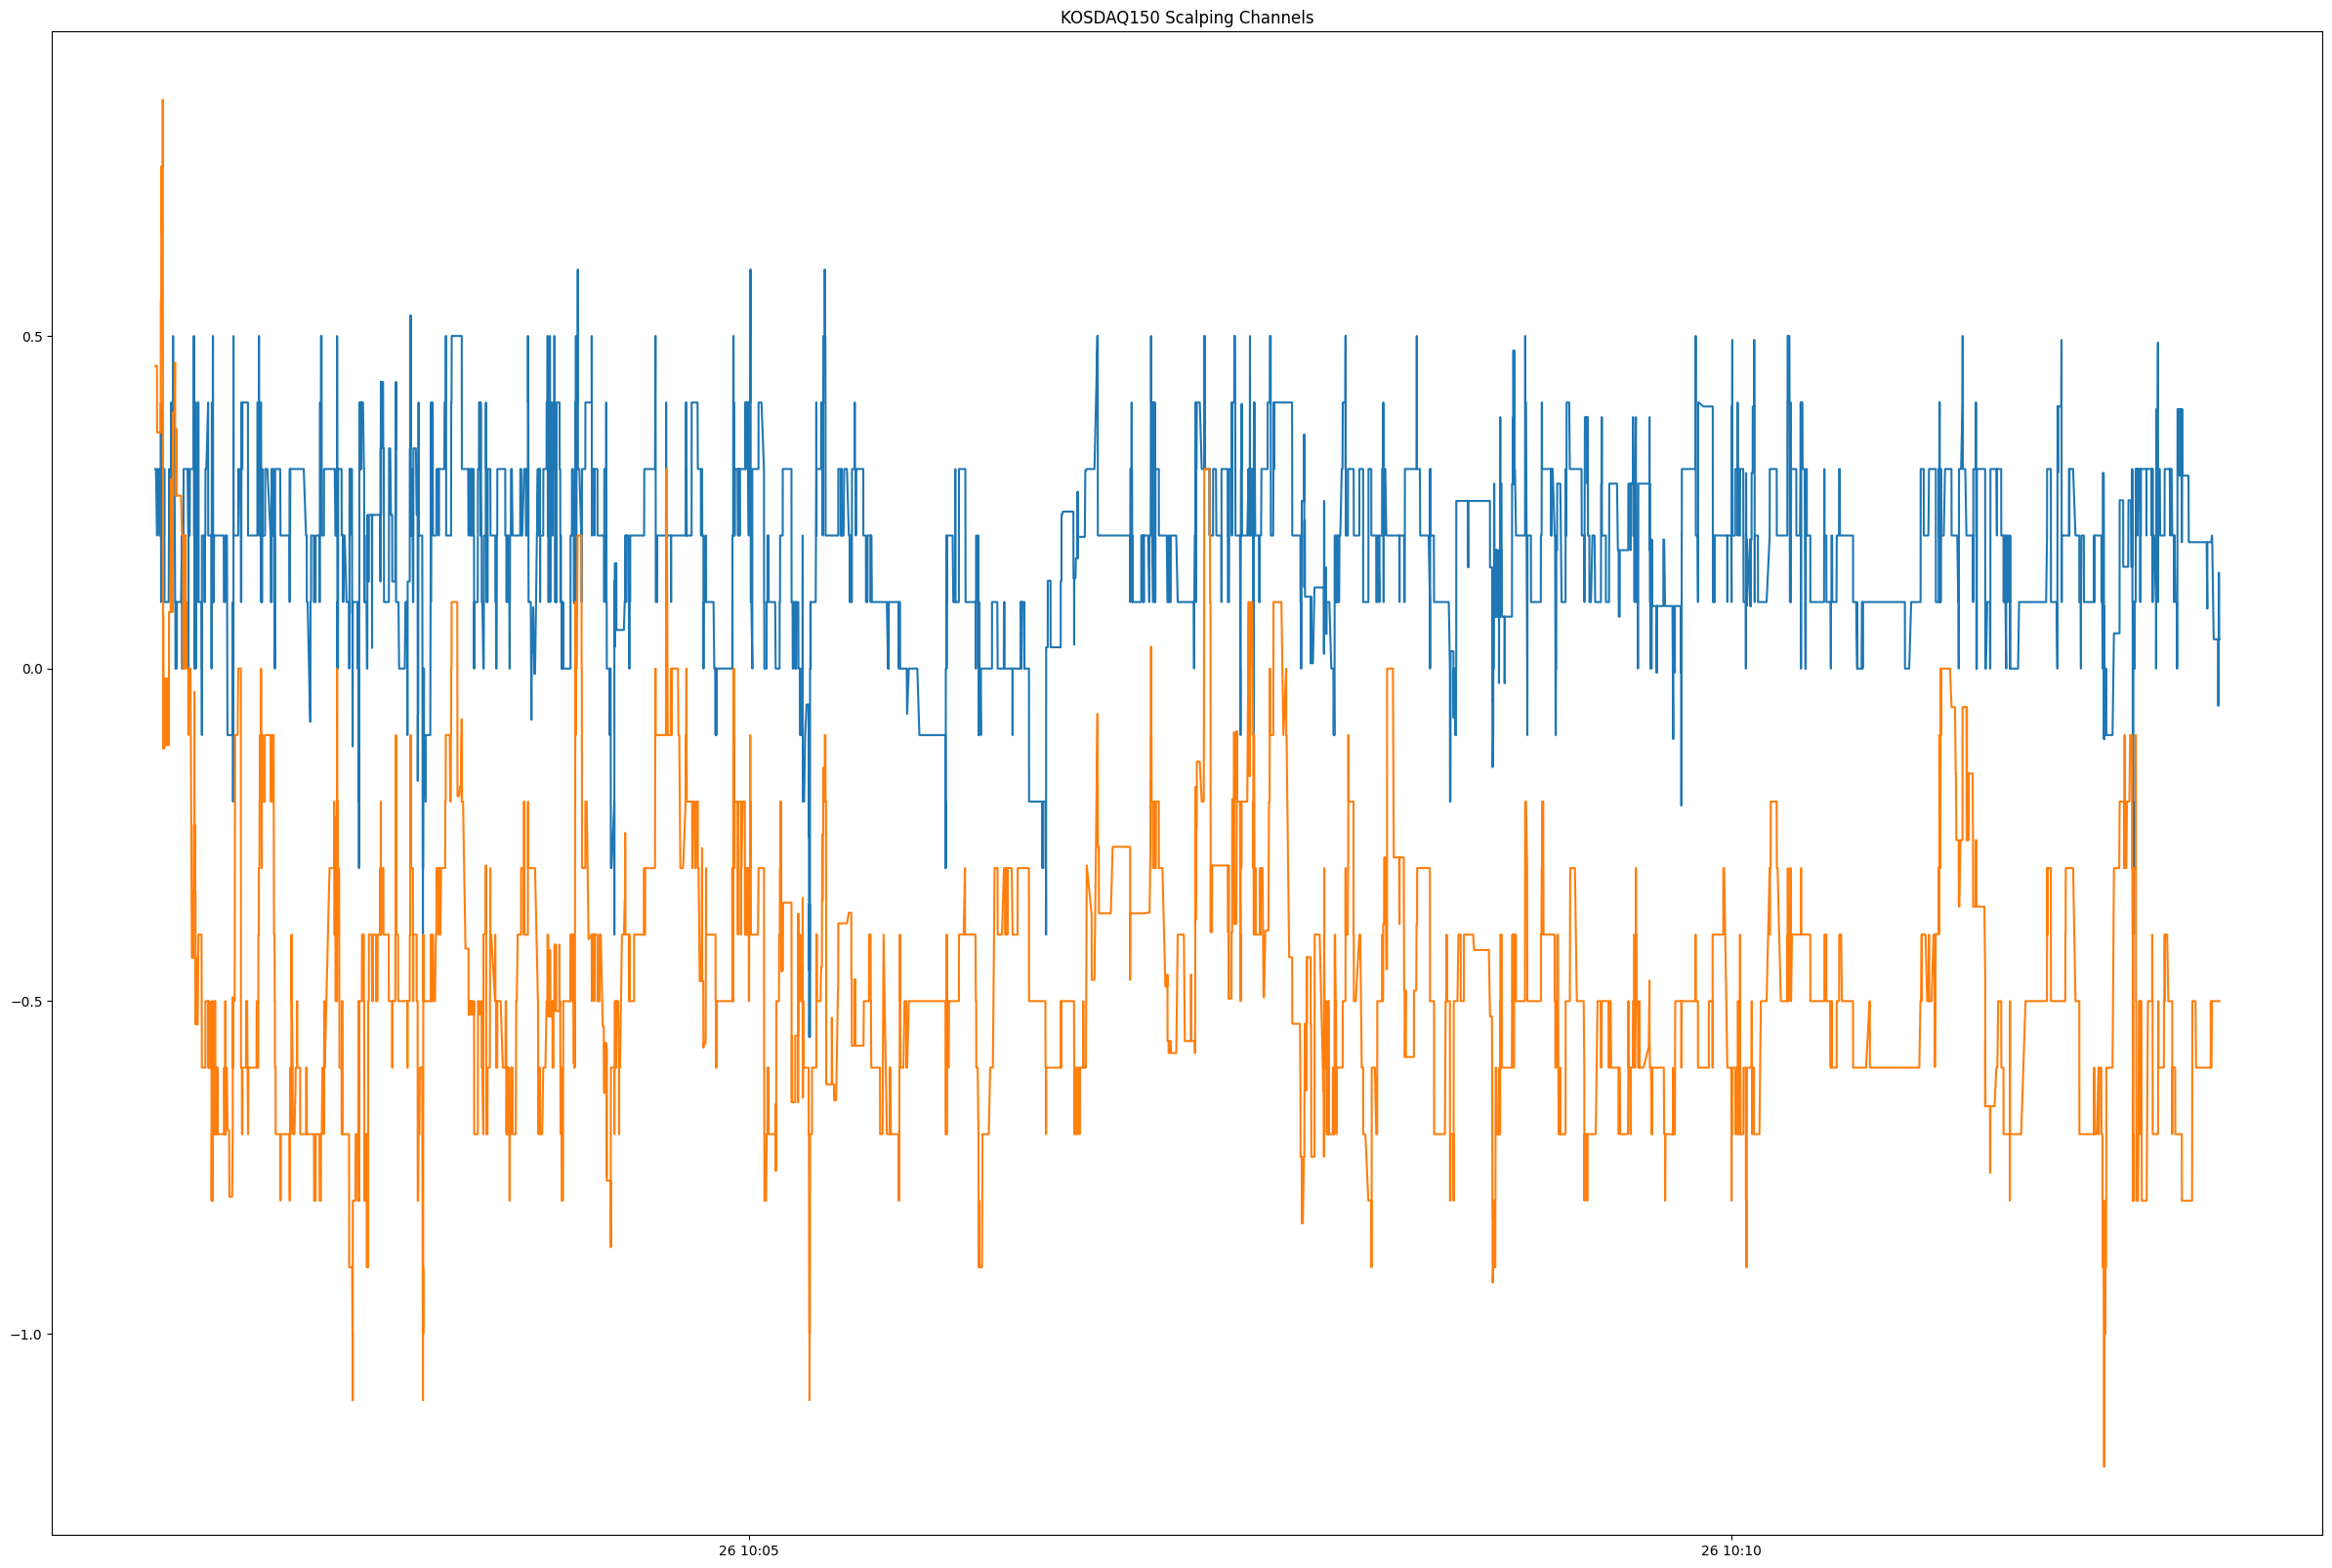

In [63]:
b, e = 1300000, 1500000
plt.figure(figsize=(30, 20))
plt.plot(datetimes_ld[b:e], upper_channels_ld[b:e])
plt.plot(datetimes_ld[b:e], lower_channels_ld[b:e])
plt.title("KOSDAQ150 Scalping Channels")
plt.show()